Assignment 2 

Image processing

L.S.Lankagama

190350F

Question 3(a)

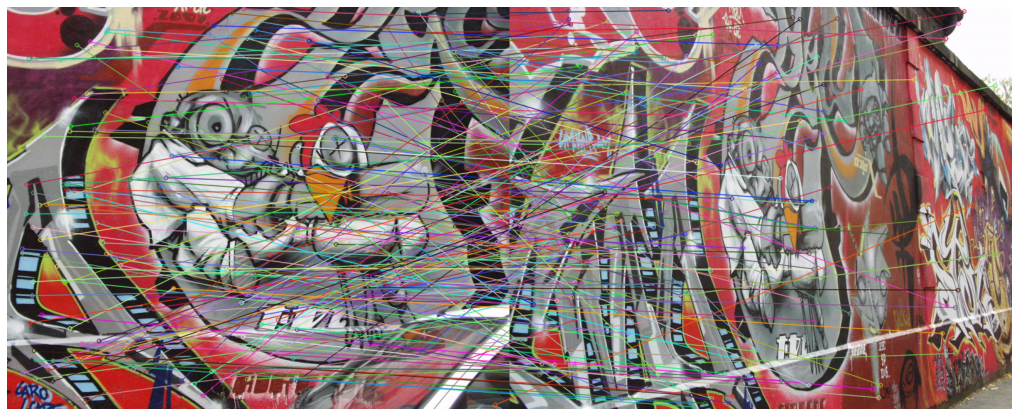

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

img1 = cv.imread(r"C:\Users\Lahiru Sanjaya\Desktop\assignment 2\img1.ppm", cv.IMREAD_COLOR)
img2 = cv.imread(r"C:\Users\Lahiru Sanjaya\Desktop\assignment 2\img5.ppm", cv.IMREAD_COLOR)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None) 
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_L1, crossCheck = True)

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:200], img2, flags =2)
fig, ax = plt.subplots(1,1, figsize = (18, 18))
plt.imshow(img3)
plt.axis('off')
plt.show()

3(b)

3(c)

Question 1

[-5.63438656  7.30345945]
0.3613332263738396
0.2656660878892028
9.245495726351068


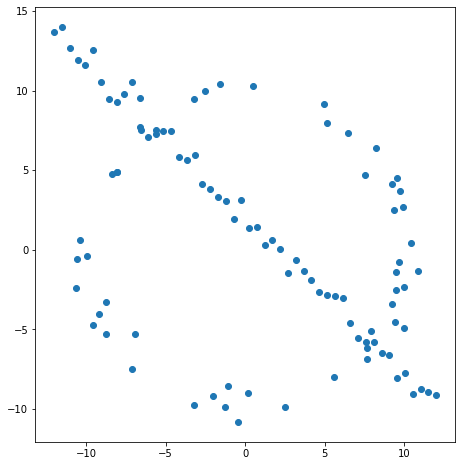

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import cv2 as cv

def get_points(index_num, circle_val):
    points = []
    for i in range(0, 3):
        points.append(circle_val[index_num[i]])
    return points
    
def getCircle(pts1, pts2, pts3):
    temp = pts2[0]**2 + pts2[1]**2
    bc = (pts1[0]**2 + pts1[1]**2 - temp)/2
    cd = (temp - pts3[0]**2 - pts3[1]**2)/2
    det = (pts1[0] - pts2[0]) * (pts2[1] - pts3[1]) - (pts2[0] - pts3[0]) * (pts1[1] - pts2[1])

    if abs(det) < 1.0e-10:
        return None
    cx = (bc*(pts2[1] - pts3[1]) - cd*(pts1[1] - pts2[1]))/ det
    cy = ((pts1[0] - pts2[0]) * cd - (pts2[0] - pts3[0])*bc)/ det

    r = ((cx - pts1[0])**2 + (cy - pts1[1])**2)**0.5

    return cx, cy, r

#np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r+n)*np.cos(t), (r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x +b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

index = np.random.choice(50, size = 3)
suitable_pts = get_points(index, X_circ)
print(suitable_pts[0])
x_val, y_val, radius = getCircle(suitable_pts[0], suitable_pts[1], suitable_pts[2])

print(x_val)
print(y_val)
print(radius)

fig, ax = plt.subplots(figsize = (8,8))
plt.plot()
ax.scatter(X[:,0],X[:,1])
ax.set_aspect('equal')
plt.show()




Question 2

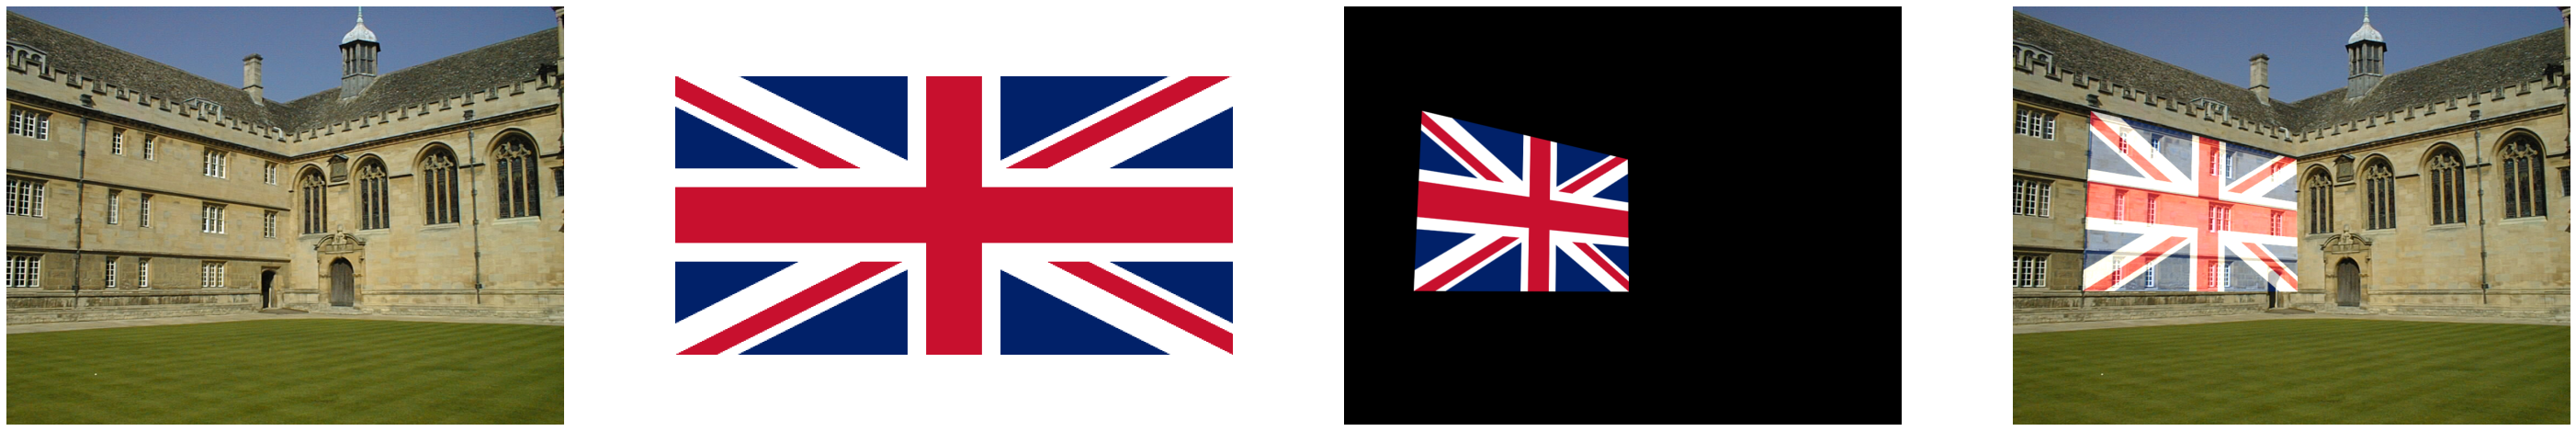

In [56]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

count = 0
points = []
width = 0
height = 0

def mousePoints(event, x, y, flags, params):
    global count
    global points
    if count < 4:
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            count += 1
    return None

def getshape(pts):
    global width
    global height
    width = (abs(pts[0][0] - pts[1][0]) + abs(pts[2][0] - pts[3][0]))//2
    height = (abs(pts[0][1] - pts[2][1]) + abs(pts[1][1] - pts[3][1]))//2

    return width, height

img1 = cv.imread(r'C:\Users\Lahiru Sanjaya\Desktop\assignment 2\001.jpg', cv.IMREAD_COLOR)
img2 = cv.imread(r'C:\Users\Lahiru Sanjaya\Desktop\assignment 2\Flag_of_the_United_Kingdom.svg.png', cv.IMREAD_REDUCED_COLOR_4)

cv.imshow("original image", img1)
cv.setMouseCallback("original image", mousePoints)
cv.waitKey(0)
cv.destroyAllWindows()


pts_src = np.array([[0,0], [480,0], [0, 240], [480,240]]) 
pts_dst = np.array(points)
shape0, shape1 = getshape(points)


h , status = cv.findHomography(pts_src, pts_dst,cv.RANSAC, 5.0)
im_out = cv.warpPerspective(img2, h, (img1.shape[1], img1.shape[0]))
blend_image = cv.addWeighted(img1, 0.95, im_out, 0.7, 0.0)


fig, ax = plt.subplots(1,4, figsize = (50,50))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0].axis('off') 
ax[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[1].axis('off') 
ax[2].imshow(cv.cvtColor(im_out, cv.COLOR_BGR2RGB))
ax[2].axis('off')
ax[3].imshow(cv.cvtColor(blend_image, cv.COLOR_BGR2RGB))
ax[3].axis('off')
plt.show()  


